In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss


model_df = pd.read_csv("../data/2015_2025_final.csv")
print(len(model_df))

2317


In [ ]:
#Relief Pitchers
print(len(model_df))
'''
model_df = model_df[
    ((model_df["IP"] >= 30) & (model_df["GS"] <= 5))
      | 
      ((model_df["Season"] == 2020) & (model_df["IP"] >= 15) & (model_df["GS"] <= 2))
    ].copy()
'''
#Starting Pitchers
model_df = model_df[
    ((model_df["IP"] >= 80) & (model_df["GS"] >= 5))
      | 
      ((model_df["Season"] == 2020) & (model_df["IP"] >= 55))
    ].copy()


2317


In [3]:
#IP dropped due to high correlation with GS
#fb_velo_mean dropped due to high correlation with fb_velo_max
#"pmv_original", "pmv_pc1", "gini_index" have high correlation 
features = [
    "Age", "IP", "WAR", "WARt-1",
    "K%", "BB%", "HR/9", "GS",
    "fb_velo_max",
    "pitch_mix_entropy",
    "whiff_rate"
]

corr = model_df[features].corr()
print(corr)

                        Age        IP       WAR    WARt-1        K%       BB%  \
Age                1.000000  0.083360 -0.003788  0.143817 -0.057556 -0.123422   
IP                 0.083360  1.000000  0.625104  0.256312  0.120119 -0.193515   
WAR               -0.003788  0.625104  1.000000  0.439057  0.598447 -0.397401   
WARt-1             0.143817  0.256312  0.439057  1.000000  0.374586 -0.201930   
K%                -0.057556  0.120119  0.598447  0.374586  1.000000 -0.087631   
BB%               -0.123422 -0.193515 -0.397401 -0.201930 -0.087631  1.000000   
HR/9               0.086503 -0.174805 -0.602259 -0.160206 -0.207057  0.070158   
GS                 0.083497  0.927945  0.523983  0.202418  0.067872 -0.109088   
fb_velo_max       -0.345565  0.117073  0.334094  0.175008  0.429659  0.111558   
pitch_mix_entropy  0.174865  0.067901 -0.026624 -0.021016 -0.176218 -0.107906   
whiff_rate        -0.082526  0.057115  0.464395  0.321320  0.873117  0.058300   

                       HR/9

In [ ]:
X = model_df[features].dropna()

X_scaled = (X - X.mean()) / X.std()

vif_df = pd.DataFrame({
    "feature": X_scaled.columns,
    "VIF": [
        variance_inflation_factor(X_scaled.values, i)
        for i in range(X_scaled.shape[1])
    ]
})

print(vif_df.sort_values("VIF", ascending=False))

              feature       VIF
1                  IP  9.786995
2                 WAR  9.559998
7                  GS  7.726450
4                  K%  6.498243
10         whiff_rate  4.600993
6                HR/9  2.735030
5                 BB%  1.811357
8         fb_velo_max  1.502554
3              WARt-1  1.333382
0                 Age  1.244549
9   pitch_mix_entropy  1.094001


In [ ]:
#Conformalized Quantile Regression (CQR) for WAR(t+1)

DATA_PATH = "/Users/wilsonschwegler/Desktop/data/2015_2025_final.csv" 

Target_year = 2025

TRAIN_YEARS = list(range(2015, Target_year - 2))   
CAL_YEAR = Target_year - 2                         
TEST_YEARS = [Target_year - 1]                     

TARGET = "WARt+1"
FEATURES = [
    "Age", "WAR", "WARt-1",
    "K%", "BB%", "HR/9", "GS",
    "fb_velo_mean",
    "pitch_mix_entropy",
    "whiff_rate"
]

#Quantiles for the model (keep 0.05/0.95; conformal will widen as needed)
Q_LO, Q_MED, Q_HI = 0.05, 0.50, 0.95
TARGET_ALPHA = 0.10  

#GBRT hyperparams 
TAIL_PARAMS = dict(
    learning_rate=0.03,
    n_estimators=800,
    max_depth=2,
    min_samples_leaf=20,
    min_samples_split=20,
    subsample=0.8,
    random_state=0,
)

MED_PARAMS = dict(
    learning_rate=0.03,
    n_estimators=1000,
    max_depth=3,
    min_samples_leaf=10,
    min_samples_split=10,
    subsample=0.8,
    random_state=0,
)


df = pd.read_csv(DATA_PATH)
'''
df = df[
    ((df["IP"] >= 35) & (df["GS"] <= 5))
      | 
      ((df["Season"] == 2020) & (df["IP"] >= 15) & (df["GS"] <= 2))
    ].copy()
'''
df = df[
    ((df["IP"] >= 120) & (df["GS"] >= 5))
      | 
      ((df["Season"] == 2020) & (df["IP"] >= 55))
    ].copy()


for c in FEATURES + [TARGET]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

train_df = df[df["Season"].isin(TRAIN_YEARS)].copy()
cal_df   = df[df["Season"] == CAL_YEAR].copy()
test_df  = df[df["Season"].isin(TEST_YEARS)].copy()

#drop rows missing features/target
train_df = train_df.dropna(subset=FEATURES + [TARGET])
cal_df   = cal_df.dropna(subset=FEATURES + [TARGET])
test_df  = test_df.dropna(subset=FEATURES + [TARGET])

X_train, y_train = train_df[FEATURES], train_df[TARGET].values
X_cal,   y_cal   = cal_df[FEATURES],   cal_df[TARGET].values
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET].values

print("Rows:", "train", len(train_df), "cal", len(cal_df), "test", len(test_df))

#FIT Quantile + Median Models
lo_model  = GradientBoostingRegressor(loss="quantile", alpha=Q_LO,  **TAIL_PARAMS).fit(X_train, y_train)
med_model = GradientBoostingRegressor(loss="quantile", alpha=Q_MED, **MED_PARAMS).fit(X_train, y_train)
hi_model  = GradientBoostingRegressor(loss="quantile", alpha=Q_HI,  **TAIL_PARAMS).fit(X_train, y_train)


#Conformal Calibration on CAL Set
q_lo_cal = lo_model.predict(X_cal)
q_hi_cal = hi_model.predict(X_cal)

#Asymmetric Calibration
r_lo = np.maximum(0, q_lo_cal - y_cal)   
r_hi = np.maximum(0, y_cal - q_hi_cal)   

qhat_lo = float(np.quantile(r_lo, 1 - TARGET_ALPHA/2, method="higher"))
qhat_hi = float(np.quantile(r_hi, 1 - TARGET_ALPHA/2, method="higher"))

print("Conformal widening qhat_lo:", qhat_lo)
print("Conformal widening qhat_hi:", qhat_hi)
q_lo_raw = lo_model.predict(X_test)
q_hi_raw = hi_model.predict(X_test)
#Apply asymmetric widening
q_lo_cqr = q_lo_raw - qhat_lo
q_hi_cqr = q_hi_raw + qhat_hi


def interval_metrics(y, lo, hi):
    cov = np.mean((y >= lo) & (y <= hi))
    width = np.mean(hi - lo)
    return cov, width

raw_cov, raw_width = interval_metrics(y_test, q_lo_raw, q_hi_raw)
cqr_cov, cqr_width = interval_metrics(y_test, q_lo_cqr, q_hi_cqr)

#Point metrics from median model (median predictions unchanged by conformal)
y_pred = med_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

#Pinball losses on test (raw quantiles)
pin_lo  = mean_pinball_loss(y_test, q_lo_raw, alpha=Q_LO)
pin_med = mean_pinball_loss(y_test, y_pred,   alpha=Q_MED)
pin_hi  = mean_pinball_loss(y_test, q_hi_raw, alpha=Q_HI)

#Pinball losses on test (cqr quantiles)
pin_lo_cqr  = mean_pinball_loss(y_test, q_lo_cqr, alpha=Q_LO)
pin_hi_cqr  = mean_pinball_loss(y_test, q_hi_cqr, alpha=Q_HI)

print("\n=== TEST RESULTS (point) ===")
print("MAE :", mae)

print("\n=== TEST RESULTS (pinball, raw quantiles) ===")
print(f"q{Q_LO:.2f}:", pin_lo)
print(f"q{Q_MED:.2f}:", pin_med)
print(f"q{Q_HI:.2f}:", pin_hi)

print("\n=== TEST RESULTS (pinball, cqr quantiles) ===")
print(f"q{Q_LO:.2f}:", pin_lo_cqr)
print(f"q{Q_MED:.2f}:", pin_med)
print(f"q{Q_HI:.2f}:", pin_hi_cqr)

print("\n=== TEST RESULTS (intervals) ===")
print(f"RAW  interval (q{Q_LO:.2f}–q{Q_HI:.2f}) coverage:", raw_cov, "avg width:", raw_width)
print(f"CQR  interval (conformalized)      coverage:", cqr_cov, "avg width:", cqr_width)

def winkler_score(y, lo, hi, alpha):
    width = hi - lo
    penalty_lo = np.maximum(0, lo - y)
    penalty_hi = np.maximum(0, y - hi)
    penalty = (2 / alpha) * (penalty_lo + penalty_hi)
    return np.mean(width + penalty)
winkler_raw = winkler_score(y_test, q_lo_raw, q_hi_raw, TARGET_ALPHA)
winkler_cqr = winkler_score(y_test, q_lo_cqr, q_hi_cqr, TARGET_ALPHA)
print("\n=== Winkler scores (lower is better) ===")
print("RAW :", winkler_raw)
print("CQR :", winkler_cqr)


pred_df = (
    test_df.copy()
    if all(c in test_df.columns for c in ["IDfg","Name","Season"])
    else test_df[["Season"]].copy()
)
pred_df["y_true"] = y_test
pred_df[f"q{Q_LO:.2f}_raw"] = q_lo_raw
pred_df[f"q{Q_HI:.2f}_raw"] = q_hi_raw
pred_df[f"q{Q_LO:.2f}_cqr"] = q_lo_cqr
pred_df[f"q{Q_HI:.2f}_cqr"] = q_hi_cqr
pred_df["q0.50"] = y_pred


Rows: train 604 cal 84 test 87
Conformal widening qhat_lo: 0.0
Conformal widening qhat_hi: 0.05074837723307768

=== TEST RESULTS (point) ===
MAE : 1.1270675773504468

=== TEST RESULTS (pinball, raw quantiles) ===
q0.05: 0.11781237601152028
q0.50: 0.5635337886752234
q0.95: 0.15483215034220782

=== TEST RESULTS (pinball, cqr quantiles) ===
q0.05: 0.11781237601152028
q0.50: 0.5635337886752234
q0.95: 0.15358521604208025

=== TEST RESULTS (intervals) ===
RAW  interval (q0.05–q0.95) coverage: 0.8160919540229885 avg width: 3.864134298988405
CQR  interval (conformalized)      coverage: 0.8275862068965517 avg width: 3.914882676221484

=== Winkler scores (lower is better) ===
RAW : 5.45289052707456
CQR : 5.4279518410720105


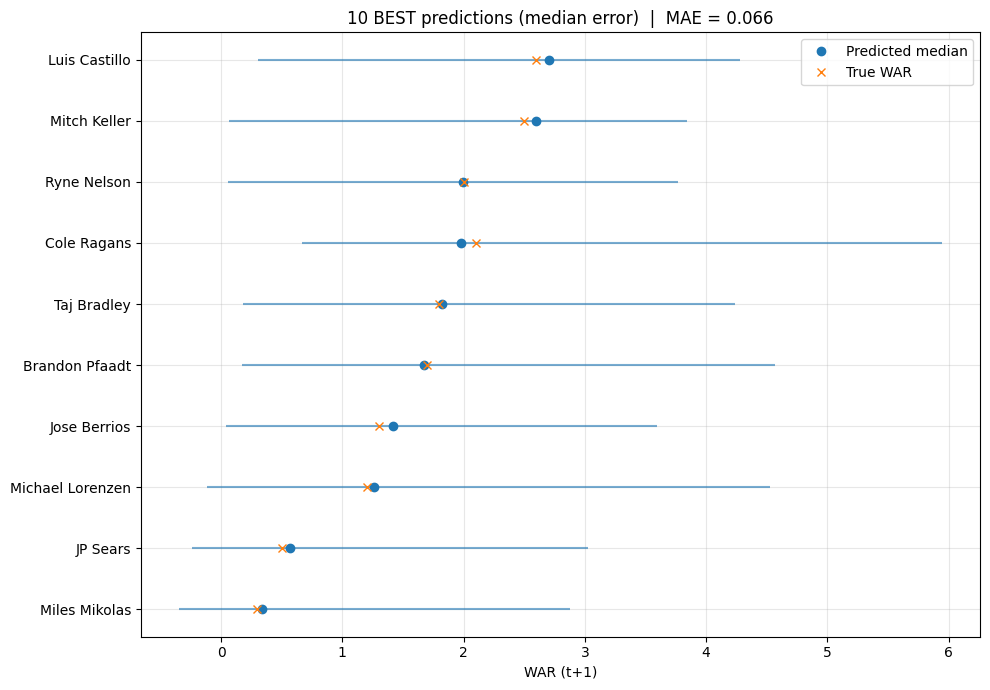

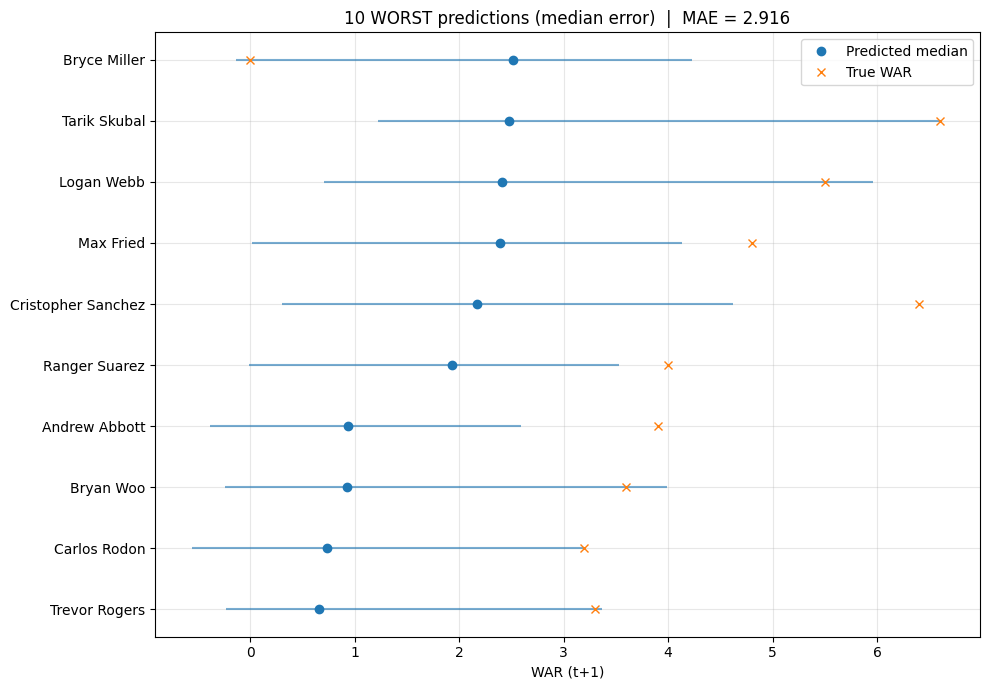

In [ ]:
def plot_intervals(df, title):
    df = df.sort_values("q0.50").copy()
    y = np.arange(len(df))

    #MAE for the subset being plotted
    mae = np.mean(np.abs(df["y_true"] - df["q0.50"]))

    plt.figure(figsize=(10, 7))
    plt.hlines(
        y=y,
        xmin=df[f"q{Q_LO:.2f}_cqr"],
        xmax=df[f"q{Q_HI:.2f}_cqr"],
        alpha=0.6
    )
    plt.plot(df["q0.50"], y, "o", label="Predicted median")
    plt.plot(df["y_true"], y, "x", label="True WAR")

    plt.yticks(y, df["Name"] if "Name" in df.columns else df.index)
    plt.xlabel("WAR (t+1)")
    plt.title(f"{title}  |  MAE = {mae:.3f}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

viz_df = pred_df.copy()
viz_df["abs_error"] = np.abs(viz_df["y_true"] - viz_df["q0.50"])

#Find the 10 BEST and WORST point estimate predictions (by median error)
best10  = viz_df.nsmallest(10, "abs_error")
worst10 = viz_df.nlargest(10, "abs_error")

plot_intervals(best10,  "10 BEST predictions (median error)")
plot_intervals(worst10, "10 WORST predictions (median error)")


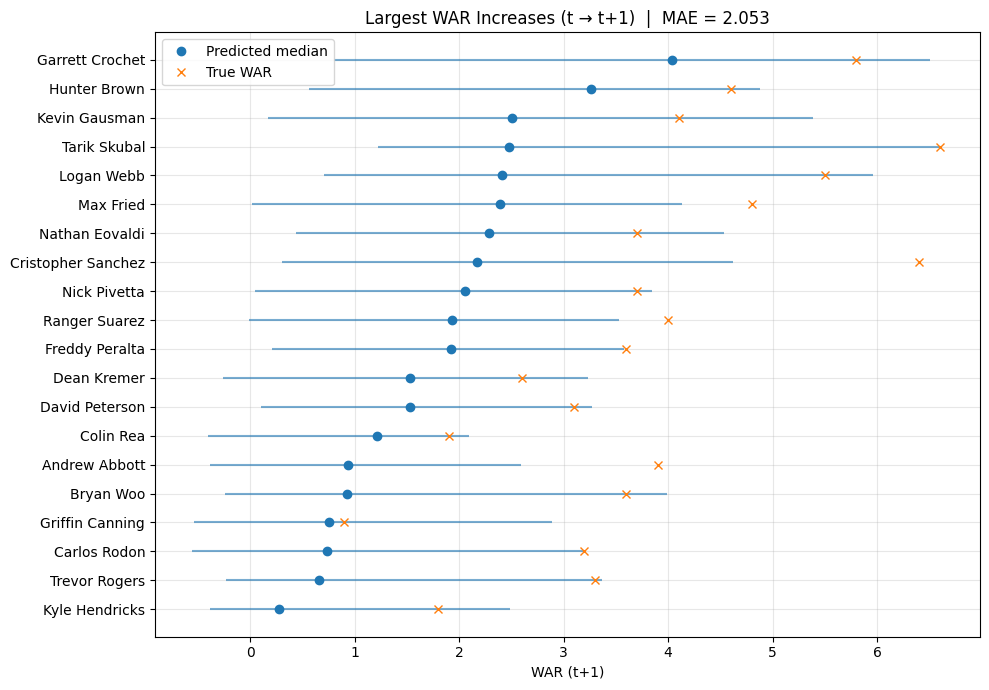

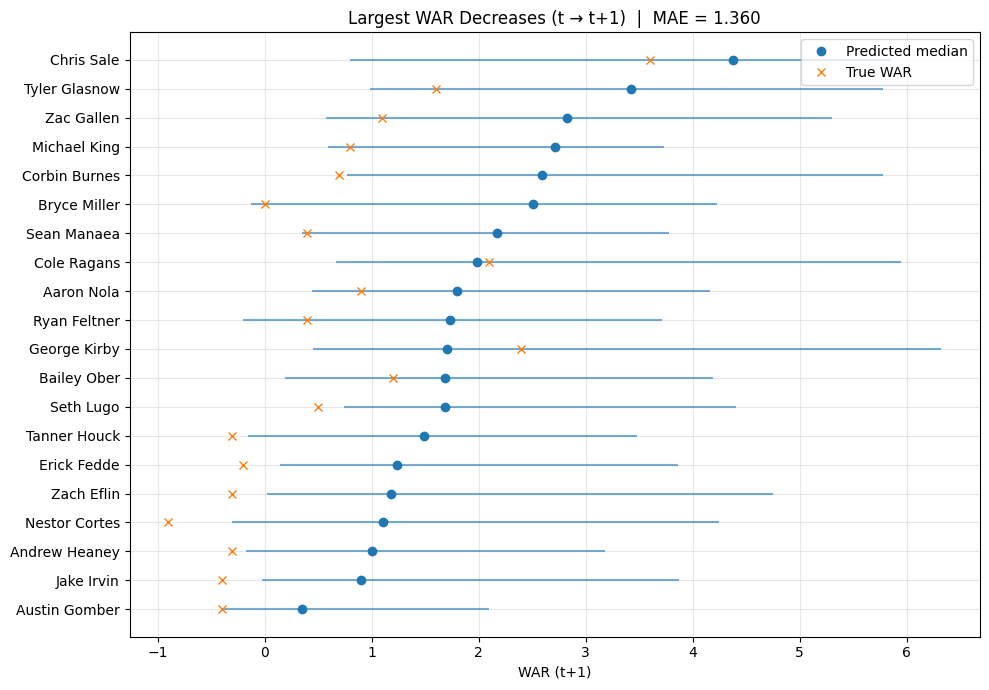

In [ ]:
#Largest WAR Changes
df_diff = df = df[df["Season"] == 2024].copy()
df_diff["WAR_diff"] = df_diff["WARt+1"] - df_diff["WAR"]

top_5_positive = (
    df_diff
    .dropna(subset=["WAR", "WARt+1"])
    .nlargest(20, "WAR_diff")
)

top_5_negative = (
    df_diff
    .dropna(subset=["WAR", "WARt+1"])
    .nsmallest(20, "WAR_diff")
)

best_names = top_5_positive["Name"].tolist()
worst_names = top_5_negative["Name"].tolist()

Best = viz_df[viz_df["Name"].isin(best_names)]
Worst = viz_df[viz_df["Name"].isin(worst_names)]

plot_intervals(Best,  "Largest WAR Increases (t → t+1)")
plot_intervals(Worst, "Largest WAR Decreases (t → t+1)")